In [3]:
import cv2
import io
from IPython.display import display, Image as IPImage
import numpy as np
import random
import pytesseract
import cv2
import os

In [4]:
file_name='images/table_3.png'
display_result = True

In [5]:
def view(img):
    is_success, buffer = cv2.imencode(".png", img)
    io_buf = io.BytesIO(buffer)
    display(IPImage(data=io_buf.getvalue(), format='png'))

In [6]:
def find_columns(contours, column_threshold):
    columns = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h / w > column_threshold and w < 10: 
            columns.append((x, y, w, h))
    return columns

In [7]:
def remove_columns(image, columns):
    for (x, y, w, h) in columns:
       image[y:y+h, x:x+w] = 0
    return image

In [8]:
def crop_width(img, width):
    cropped_slice = img[:, width:]
    height = img.shape[0]
    white_slice = np.full((height, width, img.shape[2]), 255, dtype=np.uint8)
    new_img = np.concatenate(( white_slice, cropped_slice), axis=1)
    return new_img

In [9]:
def crop_region(img, region):
    x, y, w, h = region
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

In [10]:
def draw_rectangles(image, rectangles):
    for recs in rectangles:
        rec_1, rec_2 = recs
        x1, y1, w1, h1 = rec_1
        x2, y2, w2, h2 = rec_2
        random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        # cv2.rectangle(original_image, (x, y), (x + w, y + h), random_color, 2)
        cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), random_color, 2)
        cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), random_color, 2)

In [11]:
def interpolate_column(columns):
    merged_columns = []
    i = 0
    while i < len(columns):
        # Current column to merge
        x, y, w, h = columns[i]

        # Initialize merged column properties
        total_x = x
        min_y = y
        max_y = y + h
        count = 1

        # Check for neighboring columns to merge
        for j in range(i + 1, len(columns)):
            next_x, next_y, next_w, next_h = columns[j]

            # If the x difference is within the threshold, merge the columns
            if abs(next_x - x) <= 5:
                total_x += next_x
                min_y = min(min_y, next_y)
                max_y = max(max_y, next_y + next_h)
                count += 1
                i = j
            else:
                break

        # Calculate average x and final height
        avg_x = total_x // count
        final_h = max_y - min_y

        # Add the merged column
        merged_columns.append((avg_x, min_y, w, final_h))
        i += 1

    return merged_columns

In [12]:
def process_columns(img_original):
    img = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_and(img, img, mask=mask)
    ret, img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    img = cv2.dilate(img, kernel, iterations=1)
    # view(img)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    columns = find_columns(contours, 1)
    img_without_columns = remove_columns(img, columns)
    view(img_without_columns)
    columns = sorted(columns, key=lambda column: column[0])
    merged_columns = interpolate_column(columns)
    return img_without_columns, merged_columns
    

In [13]:
def process_lines(image):
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 12))
    result = cv2.erode(image,vertical_kernel,iterations = 1)
    if (display_result): view(result)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (800, 14))
    result = cv2.dilate(result, horizontal_kernel, iterations=1)
    if (display_result): view(result)
    contours, hierarchy = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    lines = []
    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)
        lines.append((x, y, w, h))

    lines = sorted(lines, key=lambda line: line[1])
    return result, lines
    


In [14]:
def combine_lines_and_columns(lines, columns):
    cells = []
    for line in lines:
        x_line, y_line, w_line, h_line = line
        tracking_number_cell = (columns[1][0], y_line, columns[2][0] - columns[1][0], h_line)
        total_cell = (columns[5][0], y_line, columns[6][0] - columns[5][0], h_line)
        cells.append((tracking_number_cell, total_cell))
            
    return cells


In [15]:
def save_image_and_text(section, text, index, original_image, folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # File naming based on the cell index and folder path
    image_filename = os.path.join(folder_path, f"{index}.png")
    text_filename = os.path.join(folder_path, f"{index}.gt.txt")

    # Saving the section image
    cv2.imwrite(image_filename, section)

    # Saving the OCR text
    with open(text_filename, 'w') as file:
        file.write(text)


In [16]:
def filter_tracking_numbers(text_array):
    tracking_numbers = []
    for i in range(1, len(text_array), 7):
        tracking_numbers.append(text_array[i].strip())
    return tracking_numbers
        

In [17]:
def process_cell(image, cell):
    section = crop_region(original_image, cell)
    section = crop_width(section, 3)
    section = cv2.cvtColor(section, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(section, 0, 255, cv2.THRESH_BINARY)
    section = cv2.bitwise_and(section, section, mask=mask)
    text = pytesseract.image_to_string(section, config=custom_oem_psm_config)
    return section, text.split()

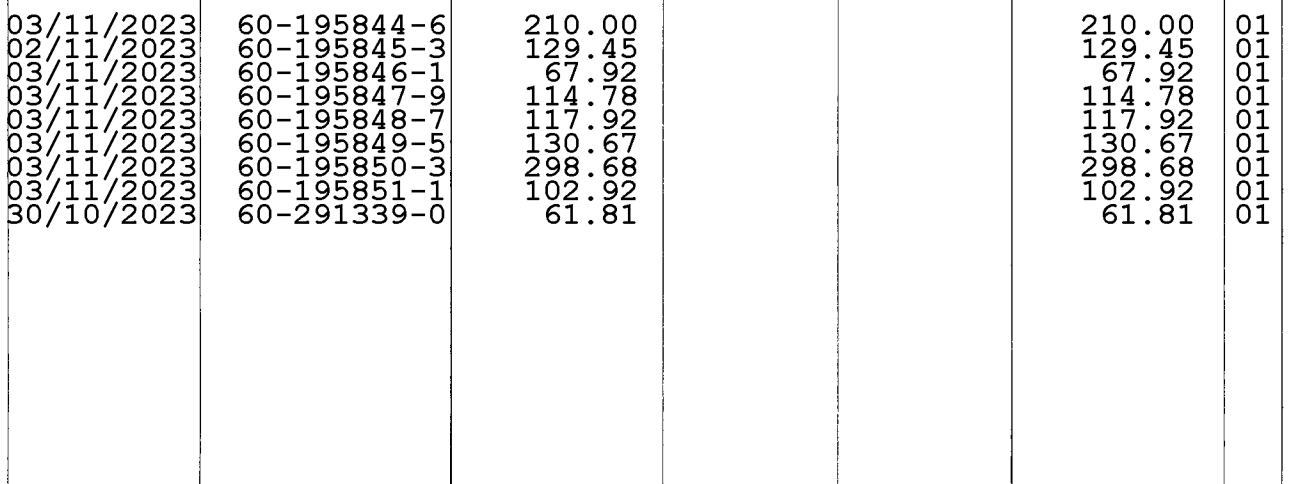

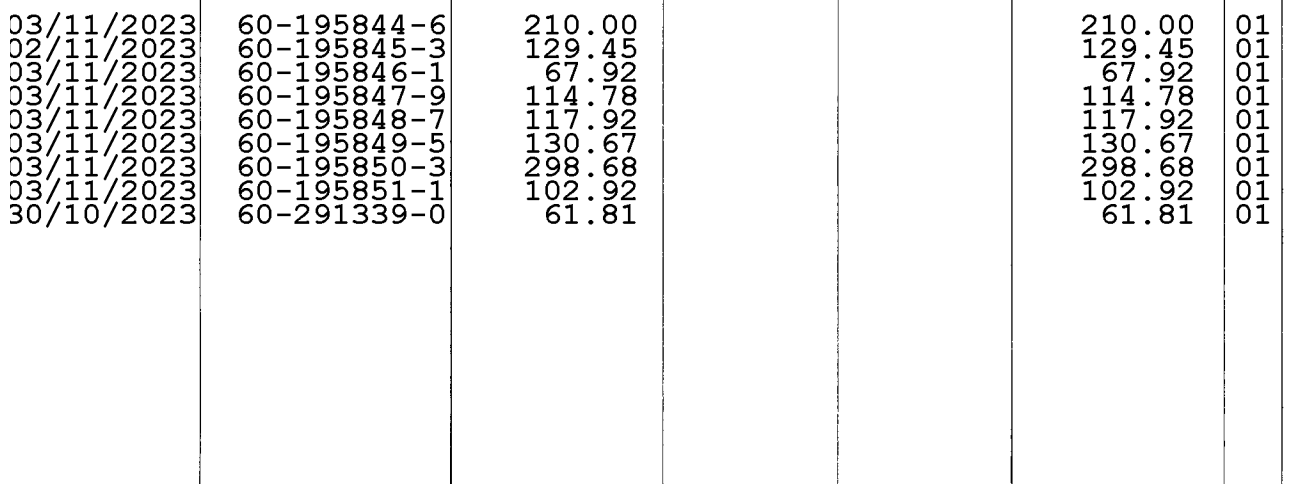

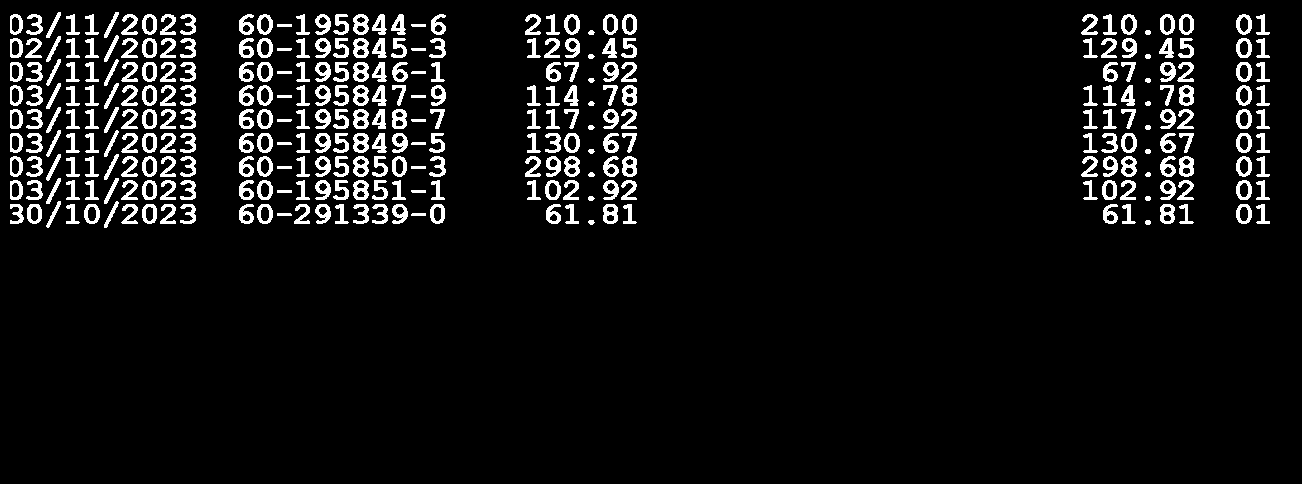

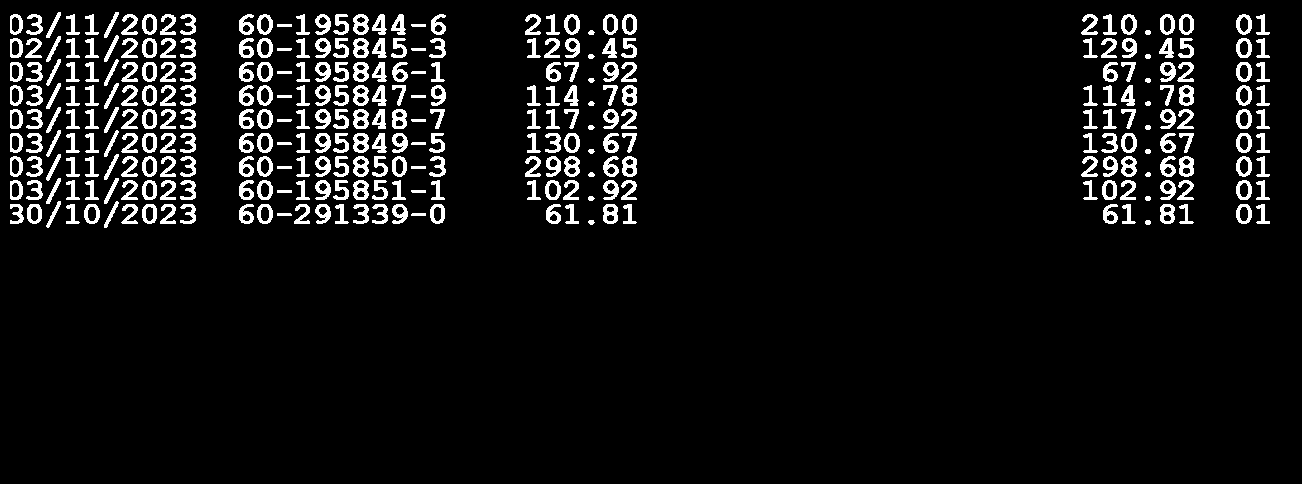

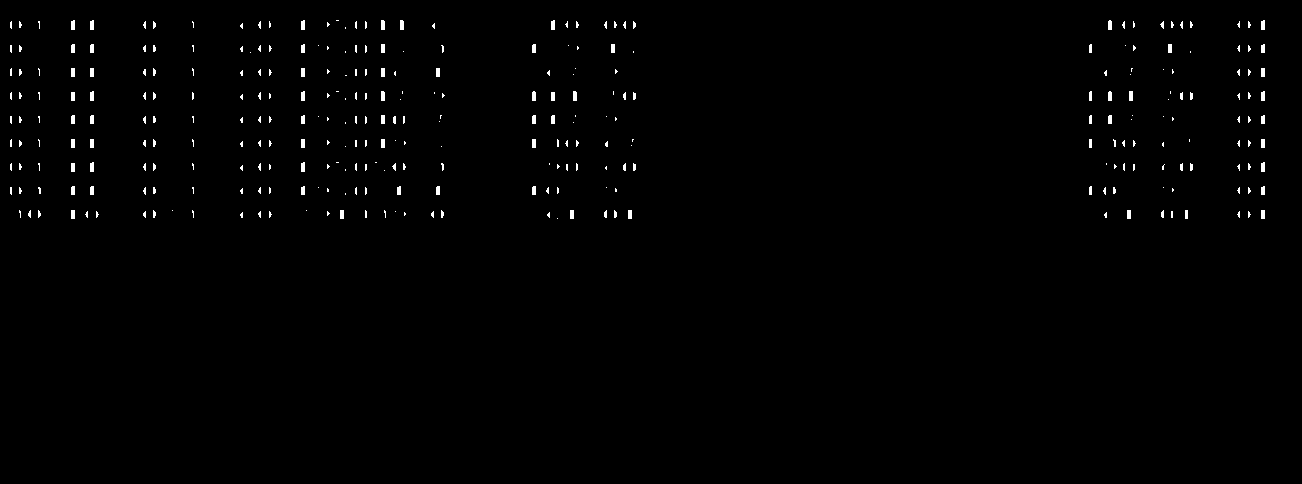

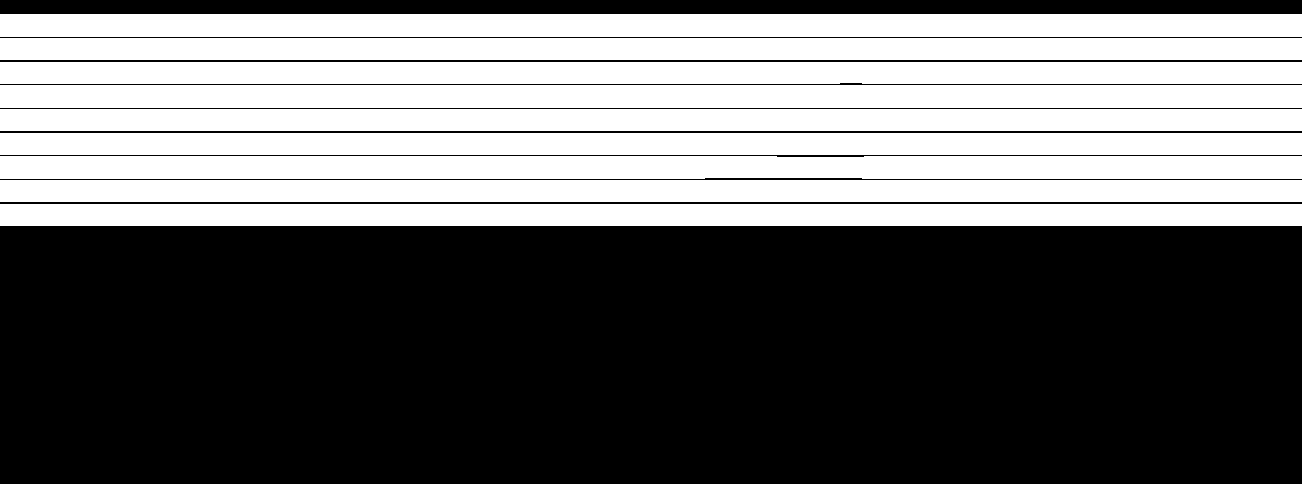

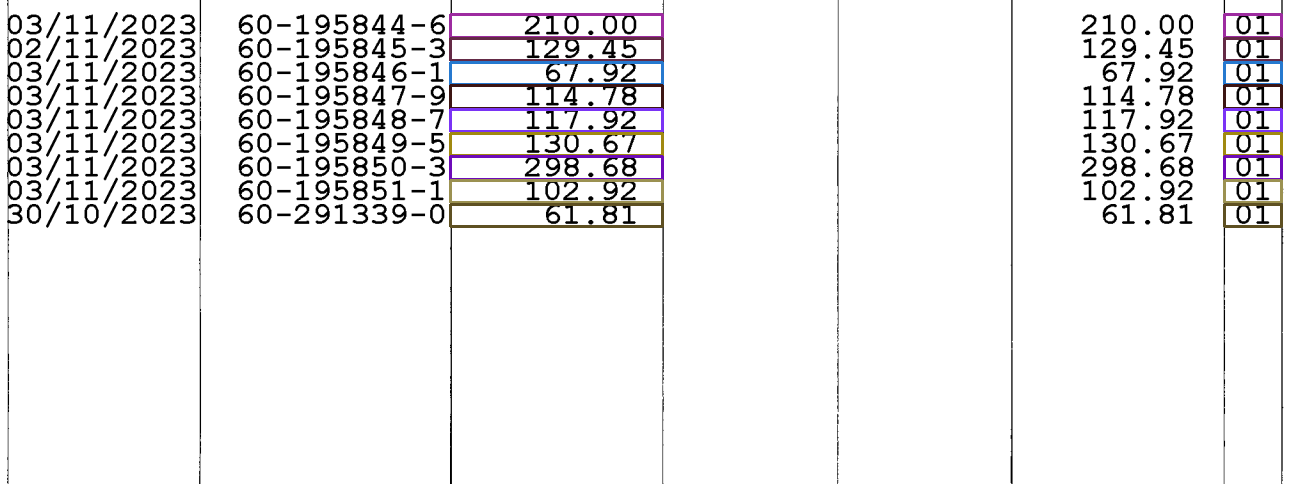

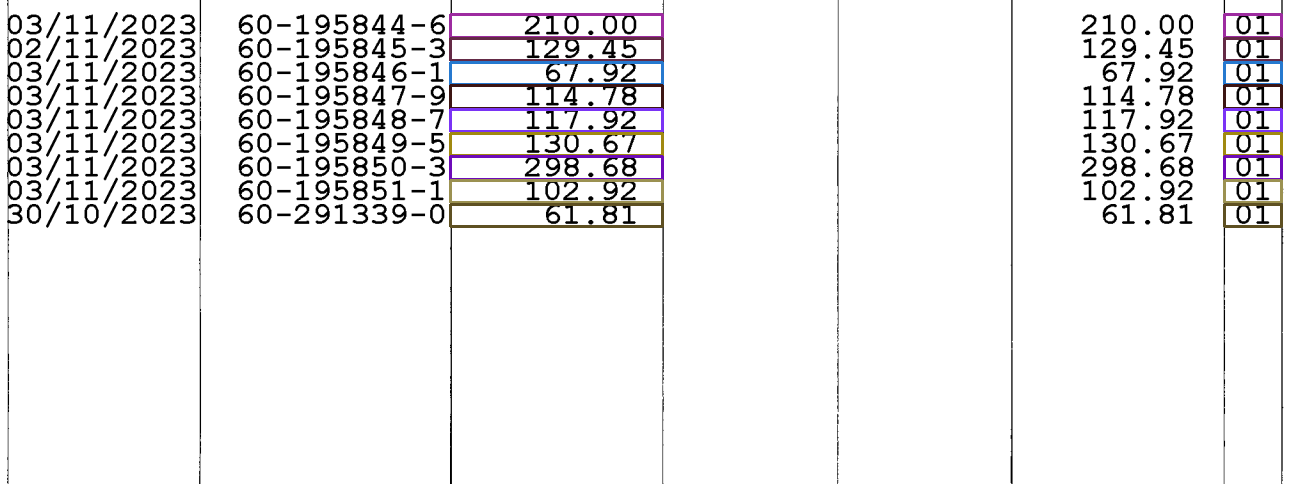

9


[(['210.00'], ['01']), (['1329.45'], ['01']), (['67.92'], ['01']), (['114.78'], ['01']), (['11..92'], ['01']), (['130.67'], ['01']), (['220710898.68'], ['01']), (['102.92'], ['01']), (['61.81'], ['01'])]


In [18]:
original_image = cv2.imread(file_name)
view(original_image)
image = crop_width(original_image, 10)
if (display_result): view(image)
result, columns = process_columns(image)
if (display_result): view(result)
result, lines = process_lines(result)
cells = combine_lines_and_columns(lines, columns)
draw_rectangles(original_image, cells)
view(original_image)
custom_oem_psm_config = r'--psm 8 -l guilbault'
if (display_result): view(original_image)
text_array = []
print(len(cells))
for cell in cells:
    cell_1, cell_2 = cell
    section_1, text_1 = process_cell(original_image, cell_1)
    section_2, text_2 = process_cell(original_image, cell_2)
    text_array.append((text_1, text_2))

print(text_array)
